In [1]:
import numpy as np
import h5py
import unet_uae as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
input_shape=(80,80,2)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary()

output shape is  (None, 10, 80, 80, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 80, 80, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 16)   304         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 40, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 40, 40, 16)   0           batch_normalization_1[0][0]      
______________________________________________________________________

In [3]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [4]:
data_dir = '/data3/Astro/cnn_surrogate_meng/topics/channel_80x80_l100_10step_2000days/data/'
# load training data
data_path = os.path.join(data_dir, 'channel_80x80_25w_lhs2967_bhp3_2000d_runs_3.h5')
sat_t, logk = load_data(data_path, ['sat', 'logk'])

sat_t[sat_t < 0.1] = 0.1
sat_t[sat_t > 1] = 1
# load eval data
print('sat_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)

sat_t shape is  (2967, 41, 80, 80)
logk shape is  (2967, 1, 80, 80)


In [5]:
step_index = [1, 2, 4, 6, 8, 10, 12, 14, 17, 20]
depth = 10
nr = logk.shape[0]
train_nr = 1500
test_nr = 50
train_x = np.concatenate([logk[:train_nr, ...],sat_t[:train_nr,[0], ...]], axis = 1)
train_y = sat_t[:train_nr,step_index,...]

test_x = np.concatenate([logk[nr-test_nr:, ...],  sat_t[nr-test_nr:, [0], ...]], axis = 1)
test_y = sat_t[nr-test_nr:,step_index,...]


train_x = train_x.transpose(0,2,3,1)
train_y = train_y[:,:,:,:,None]
test_x = test_x.transpose(0,2,3,1)
test_y = test_y[:,:,:,:,None]
#test_y = test_y.transpose(0,2,3,1)
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)


train_x shape is  (1500, 80, 80, 2)
train_y shape is  (1500, 10, 80, 80, 1)
test_x shape is  (50, 80, 80, 2)
test_y shape is  (50, 10, 80, 80, 1)


<Figure size 432x288 with 0 Axes>

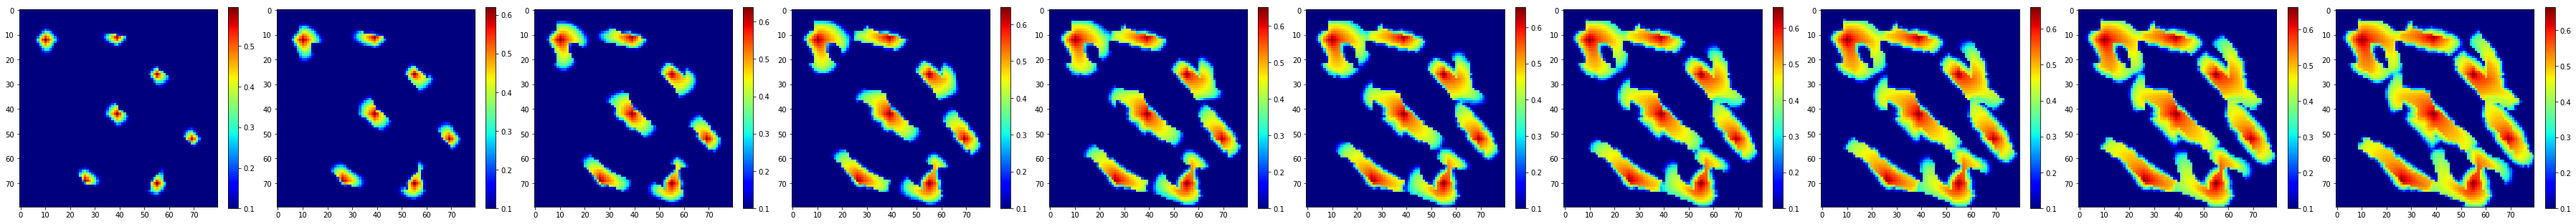

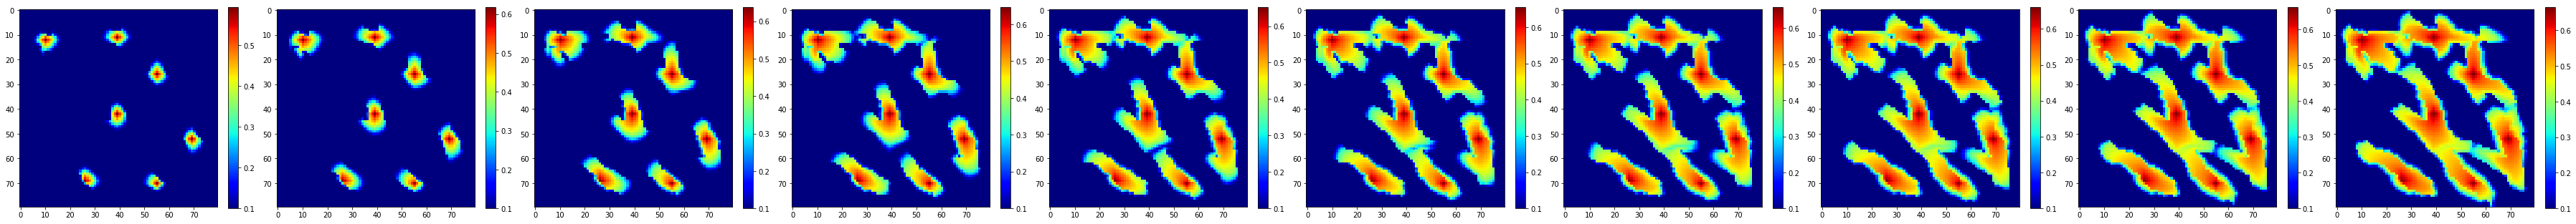

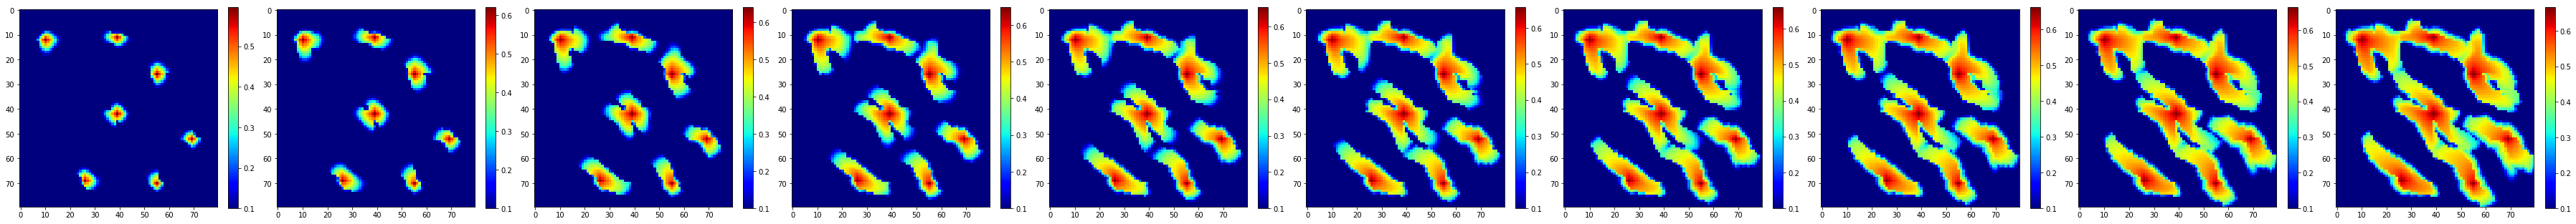

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20]

for k in range(len(ind_case)):
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(1, depth, i_tstep+1)
        plt.imshow(train_y[k, i_tstep, :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

In [7]:
output_dir = 'saved_models/'
epochs = 500
train_nr = train_x.shape[0]
test_nr = 10
batch_size = 8
num_batch = int(train_nr/batch_size) 

In [8]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

In [9]:
opt = Adam(lr=3e-3)
vae_model.compile(loss = vae_loss, optimizer = opt, metrics = [relative_error])

In [10]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 15, cooldown = 1, verbose = 1, min_lr = 1e-6)
filePath = 'saved_models/saved-model-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', period = 20)

callbacks_list = [lrScheduler, checkPoint]

In [11]:
history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y), callbacks = callbacks_list)

Train on 1500 samples, validate on 50 samples
Epoch 1/500
1500/1500 [==============================] - 31s 21ms/step - loss: 2390.2847 - relative_error: 0.7848 - val_loss: 851.7010 - val_relative_error: 0.5722
Epoch 2/500
1500/1500 [==============================] - 24s 16ms/step - loss: 668.7116 - relative_error: 0.4458 - val_loss: 1061.9778 - val_relative_error: 0.6812
Epoch 3/500
1500/1500 [==============================] - 24s 16ms/step - loss: 372.7184 - relative_error: 0.3121 - val_loss: 1449.8939 - val_relative_error: 0.8013
Epoch 4/500
1500/1500 [==============================] - 23s 16ms/step - loss: 209.2183 - relative_error: 0.2220 - val_loss: 1376.6565 - val_relative_error: 0.7863
Epoch 5/500
1500/1500 [==============================] - 24s 16ms/step - loss: 145.6295 - relative_error: 0.1810 - val_loss: 1340.7319 - val_relative_error: 0.7832
Epoch 6/500
1500/1500 [==============================] - 24s 16ms/step - loss: 110.1120 - relative_error: 0.1548 - val_loss: 950.1989 

1500/1500 [==============================] - 28s 19ms/step - loss: 5.8453 - relative_error: 0.0265 - val_loss: 12.6589 - val_relative_error: 0.0373

Epoch 00100: saving model to saved_models/saved-model-100-12.66.h5
Epoch 101/500
1500/1500 [==============================] - 28s 19ms/step - loss: 6.8099 - relative_error: 0.0248 - val_loss: 13.3481 - val_relative_error: 0.0422
Epoch 102/500
1500/1500 [==============================] - 28s 19ms/step - loss: 6.4106 - relative_error: 0.0274 - val_loss: 9.2509 - val_relative_error: 0.0328
Epoch 103/500
1500/1500 [==============================] - 28s 19ms/step - loss: 5.6809 - relative_error: 0.0253 - val_loss: 9.5721 - val_relative_error: 0.0346
Epoch 104/500
1500/1500 [==============================] - 28s 19ms/step - loss: 5.4429 - relative_error: 0.0262 - val_loss: 7.0187 - val_relative_error: 0.0240
Epoch 105/500
1500/1500 [==============================] - 28s 19ms/step - loss: 5.5127 - relative_error: 0.0264 - val_loss: 7.9584 - val_r

Epoch 150/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.9189 - relative_error: 0.0199 - val_loss: 7.5164 - val_relative_error: 0.0206
Epoch 151/500
1500/1500 [==============================] - 28s 19ms/step - loss: 4.4408 - relative_error: 0.0223 - val_loss: 9.2462 - val_relative_error: 0.0255
Epoch 152/500
1500/1500 [==============================] - 28s 19ms/step - loss: 4.1836 - relative_error: 0.0220 - val_loss: 7.1886 - val_relative_error: 0.0224
Epoch 153/500
1500/1500 [==============================] - 28s 19ms/step - loss: 4.2561 - relative_error: 0.0222 - val_loss: 6.7603 - val_relative_error: 0.0191
Epoch 154/500
1500/1500 [==============================] - 28s 19ms/step - loss: 4.0826 - relative_error: 0.0205 - val_loss: 6.5365 - val_relative_error: 0.0183
Epoch 155/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.8312 - relative_error: 0.0191 - val_loss: 8.6100 - val_relative_error: 0.0220
Epoch 156/500
1500/1500 [=========

1500/1500 [==============================] - 28s 19ms/step - loss: 3.5572 - relative_error: 0.0192 - val_loss: 6.7788 - val_relative_error: 0.0184

Epoch 00200: saving model to saved_models/saved-model-200-6.78.h5
Epoch 201/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.5520 - relative_error: 0.0188 - val_loss: 7.4433 - val_relative_error: 0.0201
Epoch 202/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.3832 - relative_error: 0.0188 - val_loss: 7.7157 - val_relative_error: 0.0207
Epoch 203/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.5581 - relative_error: 0.0212 - val_loss: 8.9529 - val_relative_error: 0.0326
Epoch 204/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.5328 - relative_error: 0.0194 - val_loss: 7.0801 - val_relative_error: 0.0311
Epoch 205/500
1500/1500 [==============================] - 28s 19ms/step - loss: 3.5046 - relative_error: 0.0198 - val_loss: 6.1902 - val_rela

Epoch 249/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.7702 - relative_error: 0.0118 - val_loss: 5.4698 - val_relative_error: 0.0167
Epoch 250/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.8104 - relative_error: 0.0125 - val_loss: 6.1568 - val_relative_error: 0.0269
Epoch 251/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.8472 - relative_error: 0.0134 - val_loss: 5.3270 - val_relative_error: 0.0164
Epoch 252/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.7958 - relative_error: 0.0124 - val_loss: 5.3797 - val_relative_error: 0.0151
Epoch 253/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.7628 - relative_error: 0.0121 - val_loss: 5.5222 - val_relative_error: 0.0175
Epoch 254/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.7481 - relative_error: 0.0114 - val_loss: 5.5665 - val_relative_error: 0.0178
Epoch 255/500
1500/1500 [=========

1500/1500 [==============================] - 28s 19ms/step - loss: 1.6005 - relative_error: 0.0119 - val_loss: 5.8365 - val_relative_error: 0.0206
Epoch 300/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.5985 - relative_error: 0.0121 - val_loss: 5.7114 - val_relative_error: 0.0175

Epoch 00300: saving model to saved_models/saved-model-300-5.71.h5
Epoch 301/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.5900 - relative_error: 0.0116 - val_loss: 5.4028 - val_relative_error: 0.0155
Epoch 302/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.5504 - relative_error: 0.0110 - val_loss: 5.4690 - val_relative_error: 0.0151
Epoch 303/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.5606 - relative_error: 0.0114 - val_loss: 5.6930 - val_relative_error: 0.0196
Epoch 304/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.5677 - relative_error: 0.0113 - val_loss: 5.3902 - val_rela

1500/1500 [==============================] - 28s 19ms/step - loss: 1.2041 - relative_error: 0.0096 - val_loss: 5.3020 - val_relative_error: 0.0155
Epoch 399/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.2381 - relative_error: 0.0106 - val_loss: 5.2725 - val_relative_error: 0.0151
Epoch 400/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.2260 - relative_error: 0.0098 - val_loss: 5.1920 - val_relative_error: 0.0142

Epoch 00400: saving model to saved_models/saved-model-400-5.19.h5
Epoch 401/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.2272 - relative_error: 0.0098 - val_loss: 5.3755 - val_relative_error: 0.0162
Epoch 402/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.2211 - relative_error: 0.0101 - val_loss: 5.2113 - val_relative_error: 0.0147
Epoch 403/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1908 - relative_error: 0.0095 - val_loss: 5.2362 - val_rela

Epoch 448/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1731 - relative_error: 0.0098 - val_loss: 5.2714 - val_relative_error: 0.0151
Epoch 449/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1641 - relative_error: 0.0099 - val_loss: 5.3122 - val_relative_error: 0.0152
Epoch 450/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1464 - relative_error: 0.0094 - val_loss: 5.2427 - val_relative_error: 0.0144
Epoch 451/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1493 - relative_error: 0.0093 - val_loss: 5.2947 - val_relative_error: 0.0149
Epoch 452/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1415 - relative_error: 0.0093 - val_loss: 5.3007 - val_relative_error: 0.0150
Epoch 453/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1606 - relative_error: 0.0098 - val_loss: 5.2608 - val_relative_error: 0.0154
Epoch 454/500
1500/1500 [=========

1500/1500 [==============================] - 28s 19ms/step - loss: 1.1162 - relative_error: 0.0092 - val_loss: 5.3673 - val_relative_error: 0.0143
Epoch 499/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1132 - relative_error: 0.0095 - val_loss: 5.3962 - val_relative_error: 0.0150
Epoch 500/500
1500/1500 [==============================] - 28s 19ms/step - loss: 1.1147 - relative_error: 0.0095 - val_loss: 5.3306 - val_relative_error: 0.0143

Epoch 00500: saving model to saved_models/saved-model-500-5.33.h5
